# Configuration

NOTES: The warnings after the import are referred to the fact that Tensorflow 2.x versions are built to directly look for a GPU in the system. The warning can be forgot if you are not going to use the GPU. 

In [576]:
LENGTH_CHOSEN = 126520

In [250]:
!pip install fsspec

     |████████████████████████████████| 118 kB 1.8 MB/s eta 0:00:01


In [2]:
!virtualenv myenv

created virtual environment CPython3.8.10.final.0-64 in 113ms
  creator CPython3Posix(dest=/home/helemanc/Desktop/Binary_Model/myenv, clear=False, global=False)
  seeder FromAppData(download=False, pip=latest, setuptools=latest, wheel=latest, pkg_resources=latest, via=copy, app_data_dir=/home/helemanc/.local/share/virtualenv/seed-app-data/v1.0.1.debian.1)
  activators BashActivator,CShellActivator,FishActivator,PowerShellActivator,PythonActivator,XonshActivator


In [3]:
!python3 -m venv myenv

In [1]:
!source myenv/bin/activate

In [5]:
!pip install seaborn

     |████████████████████████████████| 292 kB 1.1 MB/s eta 0:00:01


In [14]:
!pip install ipywidgets

     |████████████████████████████████| 121 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 9.0 MB/s eta 0:00:01


In [2]:
import os
import librosa
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('whitegrid')
import IPython.display as ipd
import librosa.display
import numpy as np
import pickle
import scipy
import ipywidgets
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, AveragePooling1D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# from livelossplot import PlotLossesKeras
tf.config.list_physical_devices('GPU')

2021-08-20 15:40:07.763502: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-20 15:40:07.763542: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-08-20 15:40:09.345858: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


[]

2021-08-20 15:40:09.350001: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-20 15:40:09.433425: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-08-20 15:40:09.433454: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (helemanc-Latitude-5410): /proc/driver/nvidia/version does not exist


# Get data from datasets

In [434]:
main_path = '/media/helemanc/OS/Users/i2CAT/Desktop/Datasets SER/'
TESS = os.path.join(main_path, "tess/TESS Toronto emotional speech set data/") 
RAV = os.path.join(main_path, "ravdess-emotional-speech-audio/audio_speech_actors_01-24")
SAVEE = os.path.join(main_path, "savee/ALL/")
CREMA = os.path.join(main_path, "creamd/AudioWAV/")

dir_list = os.listdir(RAV)

## RADVESS

In [496]:
lst = []
emotion = []
voc_channel = []
full_path = []
modality = []
intensity = []
actors = []
phrase =[]

for root, dirs, files in tqdm(os.walk(RAV)):
    for file in files:
        try:
            #Load librosa array, obtain mfcss, store the file and the mfcss information in a new array
            # X, sample_rate = librosa.load(os.path.join(root,file), res_type='kaiser_fast')
            # mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
           
            modal = int(file[1:2])
            vchan = int(file[4:5])
            lab = int(file[7:8])
            ints = int(file[10:11])
            phr = int(file[13:14])
            act = int(file[18:20])
            # arr = mfccs, lab
            # lst.append(arr)
            
            modality.append(modal)
            voc_channel.append(vchan)
            emotion.append(lab) #only labels
            intensity.append(ints)
            phrase.append(phr)
            actors.append(act)
            
            full_path.append((root, file)) # only files
          # If the file is not valid, skip it
        except ValueError:
            continue

25it [00:00, 1398.70it/s]


In [497]:
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
emotions_list = ['neutral', 'calm', 'happy', 'sadness', 'angry', 'fear', 'disgust', 'surprise']
emotion_dict = {em[0]+1:em[1] for em in enumerate(emotions_list)}

df = pd.DataFrame([emotion, voc_channel, modality, intensity, actors, actors,phrase, full_path]).T
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'gender', 'phrase', 'path']
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'speech', 2:'song'})
df['modality'] = df['modality'].map({1: 'full AV', 2:'video only', 3:'audio only'})
df['intensity'] = df['intensity'].map({1: 'normal', 2:'strong'})
df['actors'] = df['actors']
df['gender'] = df['actors'].apply(lambda x: 'female' if x%2 == 0 else 'male')
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2:'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])

In [498]:
# remove files with noise to apply the same noise to all files for data augmentation 
df = df[~df.path.str.contains('noise')]

In [499]:
df.head()

,emotion,voc_channel,modality,intensity,actors,gender,phrase,path
0,disgust,speech,audio only,normal,1,male,Dogs are sitting by the door,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
2,disgust,speech,audio only,strong,1,male,Kids are talking by the door,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
4,disgust,speech,audio only,strong,1,male,Kids are talking by the door,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
6,disgust,speech,audio only,strong,1,male,Dogs are sitting by the door,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
8,disgust,speech,audio only,strong,1,male,Dogs are sitting by the door,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...


In [500]:
# only speech
RAV_df = df
RAV_df = RAV_df.loc[RAV_df.voc_channel == 'speech']

In [501]:
RAV_df.insert(0, "emotion_label", RAV_df.emotion, True)

In [502]:
RAV_df = RAV_df.drop(['emotion', 'voc_channel', 'modality', 'intensity', 'phrase'], 1)

In [503]:
RAV_df

,emotion_label,actors,gender,path
0,disgust,1,male,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
2,disgust,1,male,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
4,disgust,1,male,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
6,disgust,1,male,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
8,disgust,1,male,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
...,...,...,...,...
2871,neutral,24,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
2873,neutral,24,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
2875,calm,24,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
2877,calm,24,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...


In [504]:
RAV_train = []
RAV_val = []
RAV_test = []

In [505]:
for index, row in RAV_df.iterrows():
    if row['actors'] in range(1,21): 
        RAV_train.append(row) 
    elif row['actors'] in range(21,23): 
        RAV_val.append(row)
    elif row['actors'] in range(23,25): 
        RAV_test.append(row)
len(RAV_train), len(RAV_val), len(RAV_test)

(1200, 120, 120)

In [506]:
RAV_train = pd.DataFrame(RAV_train)
RAV_val = pd.DataFrame(RAV_val)
RAV_test = pd.DataFrame(RAV_test)

In [507]:
RAV_train = RAV_train.drop(['actors'], 1)
RAV_val = RAV_val.drop(['actors'], 1)
RAV_test = RAV_test.drop(['actors'], 1)

In [508]:
RAV_train.head()

,emotion_label,gender,path
0,disgust,male,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
2,disgust,male,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
4,disgust,male,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
6,disgust,male,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
8,disgust,male,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...


In [509]:
RAV_val.head()

,emotion_label,gender,path
2400,angry,male,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
2402,fear,male,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
2404,fear,male,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
2406,fear,male,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
2408,fear,male,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...


## SAVEE

In [510]:
# Get the data location for SAVEE
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
actors = []
gender = []
for i in dir_list:
    actors.append(i[:2])
    if i[-8:-6]=='_a':
        emotion.append('angry')
        gender.append('male')
    elif i[-8:-6]=='_d':
        emotion.append('disgust')
        gender.append('male')
    elif i[-8:-6]=='_f':
        emotion.append('fear')
        gender.append('male')
    elif i[-8:-6]=='_h':
        emotion.append('happy')
        gender.append('male')
    elif i[-8:-6]=='_n':
        emotion.append('neutral')
        gender.append('male')
    elif i[-8:-6]=='sa':
        emotion.append('sadness')
        gender.append('male')
    elif i[-8:-6]=='su':
        emotion.append('surprise')
        gender.append('male') 
    else:
        emotion.append('Unknown') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['emotion_label'])
                      
SAVEE_df = pd.concat([SAVEE_df,
                      pd.DataFrame(actors, columns = ['actors']),
                      pd.DataFrame(gender, columns = ['gender']), 
                      pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.emotion_label.value_counts()

neutral     120
sadness      60
surprise     60
happy        60
disgust      60
fear         60
angry        60
Name: emotion_label, dtype: int64

In [511]:
SAVEE_df.head()

,emotion_label,actors,gender,path
0,neutral,DC,male,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
1,sadness,KL,male,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
2,sadness,KL,male,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
3,sadness,KL,male,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
4,sadness,KL,male,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...


In [512]:
SAVEE_train = []
SAVEE_val = []
SAVEE_test = []

In [513]:
#DC, JE, JK, KL
for index, row in SAVEE_df.iterrows(): 
    if row['actors'] == 'DC' or row ['actors'] == 'JE':
        SAVEE_train.append(row)
    elif row['actors'] == 'JK': 
        SAVEE_val.append(row)
    else: 
        SAVEE_test.append(row)
len(SAVEE_train), len(SAVEE_val), len(SAVEE_test)

(240, 120, 120)

In [514]:
SAVEE_train = pd.DataFrame(SAVEE_train)
SAVEE_val = pd.DataFrame(SAVEE_val)
SAVEE_test = pd.DataFrame(SAVEE_test)

In [515]:
SAVEE_train = SAVEE_train.drop(['actors'], 1)
SAVEE_val = SAVEE_val.drop(['actors'], 1)
SAVEE_test = SAVEE_test.drop(['actors'], 1)

## TESS

In [516]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

path = []
emotion = []
gender = []
actors = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry':
            emotion.append('angry')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_angry': 
            emotion.append('angry')
            gender.append('female')
            actors.append('YAF')
            
            
        elif i == 'OAF_disgust' :
            emotion.append('disgust')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_disgust': 
            emotion.append('disgust')
            gender.append('female')
            actors.append('YAF')
            
            
        elif i == 'OAF_Fear':
            emotion.append('fear')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_fear': 
            emotion.append('fear')
            gender.append('female')
            actors.append('YAF') 
            
            
        elif i == 'OAF_happy' :
            emotion.append('happy')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_happy': 
            emotion.append('angry')
            gender.append('female')
            actors.append('YAF')            
            
        elif i == 'OAF_neutral':
            emotion.append('neutral')
            gender.append('female')
            actors.append('OAF')   
        elif i == 'YAF_neutral': 
            emotion.append('neutral')
            gender.append('female')
            actors.append('YAF')      
            
                
        elif i == 'OAF_Pleasant_surprise':
            emotion.append('surprise')
            gender.append('female')
            actors.append('OAF')
        
        elif i == 'YAF_pleasant_surprised': 
            emotion.append('surprise')
            gender.append('female')
            actors.append('YAF')            
            
        elif i == 'OAF_Sad':
            emotion.append('sadness')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_sad': 
            emotion.append('sadness')
            gender.append('female')
            actors.append('YAF')            
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['emotion_label'])
TESS_df = pd.concat([TESS_df, pd.DataFrame(gender, columns = ['gender']), 
                     pd.DataFrame(actors, columns= ['actors']),
                     pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.emotion_label.value_counts()

angry       1200
fear         800
surprise     800
sadness      800
disgust      800
neutral      800
happy        400
Name: emotion_label, dtype: int64

In [517]:
TESS_df= TESS_df[~TESS_df.path.str.contains('noise')]

In [518]:
TESS_train = []
TESS_test = []

In [519]:
for index, row in TESS_df.iterrows(): 
    if row['actors'] == 'YAF': 
        TESS_train.append(row)
    else: 
        TESS_test.append(row)
len(TESS_train), len(TESS_test)

(1400, 1400)

In [520]:
TESS_train = pd.DataFrame(TESS_train)
TESS_test = pd.DataFrame(TESS_test)

## CREMA-D

In [521]:
males = [1,
5,
11,
14,
15,
16,
17,
19,
22,
23,
26,
27,
31,
32,
33,
34,
35,
36,
38,
39,
41,
42,
44,
45,
48,
50,
51,
57,
59, 
62, 
64,
65, 
66,
67,
68,
69,
70,
71,
77, 
80, 
81, 
83, 
85, 
86, 
87,
88, 
90]

In [522]:
females = [ 2,
3,
4,
6,
7,
8,
9,
10,
12,
13,
18,
20,
21,
24,
25,
28,
29,
30,
37,
40,
43,
46,
47,
49,
52,
53,
54,
55,
56, 
58, 
60,
61,
63,
72, 
73, 
74, 
75, 
76, 
78, 
79, 
82, 
84, 
89, 
91]

In [523]:
crema_directory_list = os.listdir(CREMA)

file_emotion = []
file_path = []
actors = []
gender = []




for file in crema_directory_list:

    # storing file emotions
    part=file.split('_')
    
    # use only high intensity files
    if "HI" in part[3] :
        actor = part[0][2:]
        actors.append(actor)
        if int(actor) in males:
            gender.append('male')
        else: 
            gender.append('female')
    
        # storing file paths
        file_path.append(CREMA + file)
        if part[2] == 'SAD':
            file_emotion.append('sadness')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['emotion_label'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
actors_df = pd.DataFrame(actors, columns=['actors'])
gender_df = pd.DataFrame(gender, columns=['gender'])                      
Crema_df = pd.concat([emotion_df, actors_df, gender_df, path_df], axis=1)
Crema_df.head()

,emotion_label,actors,gender,path
0,happy,91,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
1,sadness,91,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
2,angry,91,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
3,disgust,91,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
4,fear,91,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...


In [524]:
Crema_df.shape

(455, 4)

In [525]:
actor_files = {}

for index, row in Crema_df.iterrows():
    actor = row['actors']
    if actor not in actor_files.keys(): 
        actor_files[actor] = 1
    else: 
        actor_files[actor]+=1

In [526]:
actor_files

{'91': 5,
 '90': 5,
 '89': 5,
 '88': 5,
 '87': 5,
 '86': 5,
 '85': 5,
 '84': 5,
 '83': 5,
 '82': 5,
 '81': 5,
 '80': 5,
 '79': 5,
 '78': 5,
 '77': 5,
 '76': 5,
 '75': 5,
 '74': 5,
 '73': 5,
 '72': 5,
 '71': 5,
 '70': 5,
 '69': 5,
 '68': 5,
 '67': 5,
 '66': 5,
 '65': 5,
 '64': 5,
 '63': 5,
 '62': 5,
 '61': 5,
 '60': 5,
 '59': 5,
 '58': 5,
 '57': 5,
 '56': 5,
 '55': 5,
 '54': 5,
 '53': 5,
 '52': 5,
 '51': 5,
 '50': 5,
 '49': 5,
 '48': 5,
 '47': 5,
 '46': 5,
 '45': 5,
 '44': 5,
 '43': 5,
 '42': 5,
 '41': 5,
 '40': 5,
 '39': 5,
 '38': 5,
 '37': 5,
 '36': 5,
 '35': 5,
 '34': 5,
 '33': 5,
 '32': 5,
 '31': 5,
 '30': 5,
 '29': 5,
 '28': 5,
 '27': 5,
 '26': 5,
 '25': 5,
 '24': 5,
 '23': 5,
 '22': 5,
 '21': 5,
 '20': 5,
 '19': 5,
 '18': 5,
 '17': 5,
 '16': 5,
 '15': 5,
 '14': 5,
 '13': 5,
 '12': 5,
 '11': 5,
 '10': 5,
 '09': 5,
 '08': 5,
 '07': 5,
 '06': 5,
 '05': 5,
 '04': 5,
 '03': 5,
 '02': 5,
 '01': 5}

In [527]:
count_males = 0 
count_females = 0 
male_list = []
for index, row in Crema_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1

In [528]:
count_males, count_females

(235, 220)

Since there are more males than females we will remove randomly 3 male actors (since there are exactly 5 audio files per actor)

In [529]:
import random 
random.seed(42)
males_to_remove = random.sample(male_list, 3)
males_to_remove

['17', '80', '88']

In [530]:
new_df = []
for index, row in Crema_df.iterrows(): 
    if row['actors'] not in males_to_remove: 
        new_df.append(row)

In [531]:
CREMA_df = pd.DataFrame(new_df)

In [532]:
for index, row in CREMA_df.iterrows(): 
    if row['actors'] == '17': 
        print("Elements not removed")

In [533]:
count_males = 0 
count_females = 0 
male_list = []
female_list = []
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1
        if actor not in female_list: 
            female_list.append(actor)

In [534]:
count_males, count_females

(220, 220)

In [535]:
len(female_list)

44

In [536]:
len(male_list)

44

In [537]:
CREMA_train = []
CREMA_val = []
CREMA_test = []

In [538]:
females_train = random.sample(female_list, 32)
males_train = random.sample(male_list, 32)

# remove the elements assigned to train 
for element in females_train:
    if element in female_list:
        female_list.remove(element)
        
for element in males_train:
    if element in male_list:
        male_list.remove(element)

         
females_val = random.sample(female_list, 6) 
males_val = random.sample(male_list, 6) 

# remove the elements assigned to val
for element in females_val:
    if element in female_list:
        female_list.remove(element)
        
for element in males_val:
    if element in male_list:
        male_list.remove(element)
        
females_test = random.sample(female_list, 6) 
males_test = random.sample(male_list, 6)        

In [539]:
females_train, males_train, females_val, males_val, females_test, males_test

(['54',
  '56',
  '58',
  '74',
  '76',
  '13',
  '78',
  '29',
  '84',
  '89',
  '09',
  '60',
  '04',
  '55',
  '52',
  '91',
  '02',
  '07',
  '46',
  '49',
  '37',
  '10',
  '20',
  '75',
  '21',
  '53',
  '06',
  '28',
  '18',
  '63',
  '30',
  '03'],
 ['57',
  '69',
  '65',
  '45',
  '77',
  '81',
  '41',
  '15',
  '44',
  '23',
  '59',
  '86',
  '34',
  '01',
  '85',
  '66',
  '31',
  '33',
  '05',
  '48',
  '50',
  '67',
  '51',
  '22',
  '36',
  '87',
  '71',
  '39',
  '42',
  '11',
  '32',
  '14'],
 ['43', '61', '40', '47', '73', '24'],
 ['62', '68', '64', '83', '70', '26'],
 ['08', '79', '12', '25', '72', '82'],
 ['16', '19', '38', '35', '27', '90'])

In [540]:
train = females_train + males_train 
val = females_val + males_val 
test = females_test + males_test

In [541]:
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if actor in train: 
        CREMA_train.append(row)
    elif actor in val: 
        CREMA_val.append(row)
    else:
        CREMA_test.append(row)

In [542]:
CREMA_train = pd.DataFrame(CREMA_train) 
CREMA_val = pd.DataFrame(CREMA_val) 
CREMA_test = pd.DataFrame(CREMA_test)

In [543]:
CREMA_train.shape, CREMA_val.shape, CREMA_test.shape

((320, 4), (60, 4), (60, 4))

In [544]:
CREMA_train.head()

,emotion_label,actors,gender,path
0,happy,91,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
1,sadness,91,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
2,angry,91,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
3,disgust,91,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
4,fear,91,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...


In [545]:
CREMA_train = CREMA_train.drop(['actors'], 1)
CREMA_val = CREMA_val.drop(['actors'], 1)
CREMA_test = CREMA_test.drop(['actors'], 1)

## Combine datasets

In [546]:
df_train = pd.concat([RAV_train, SAVEE_train, TESS_train, CREMA_train])

In [547]:
df_val = pd.concat([RAV_val, SAVEE_val, CREMA_val])

In [548]:
df_test = pd.concat([RAV_test, SAVEE_test, TESS_test, CREMA_test])

In [549]:
df_train.shape, df_val.shape, df_test.shape

((3160, 4), (300, 3), (1700, 4))

## Save dataframes to retrieve paths for Training, Val and Test

In [550]:
preprocess_path = "/home/helemanc/Desktop/Binary_Model/pre-processed"

In [551]:
df_train.to_csv(os.path.join(preprocess_path,"df_train.csv"), index=False)

In [552]:
df_val.to_csv(os.path.join(preprocess_path,"df_val.csv"), index=False)

In [553]:
df_test.to_csv(os.path.join(preprocess_path,"df_test.csv"), index=False)

# Load Dataframes

In [554]:
preprocess_path = "/home/helemanc/Desktop/Binary_Model/pre-processed"

df_train = pd.read_csv(os.path.join(preprocess_path,"df_train.csv"))
df_val = pd.read_csv(os.path.join(preprocess_path,"df_val.csv"))
df_test = pd.read_csv(os.path.join(preprocess_path,"df_test.csv"))                      

# Check Bit-Depth of wav files

In [423]:
from soundfile import SoundFile

In [418]:
ravdess_bd = []
savee_bd = []
tess_bd = []
crema_bd = []


for index, row in df_train.iterrows(): 
    path = row['path']
    file = SoundFile(path)
    if 'ravdess' in path:
        ravdess_bd.append(file.subtype)
    elif 'savee' in path: 
        savee_bd.append(file.subtype)
    elif 'creamd' in path: 
        crema_bd.append(file.subtype) 
    else: 
        tess_bd.append(file.subtype)
         

In [419]:
# check that all the audio files of a dataset have the same bith depth 
for el in ravdess_bd: 
    if el != 'PCM_16':
        print('Diff')

In [407]:
for el in savee_bd: 
    if el != 'PCM_16':
        print('Diff')

In [408]:
for el in tess_bd: 
    if el != 'PCM_16':
        print('Diff')

In [409]:
for el in crema_bd: 
    if el != 'PCM_16':
        print('Diff')

# Check the volume of wav files - PENDING 

To check the volume we are going to compute the rms for each audio files. Later we will plot the distribution of the volume for each database. 
https://docs.python.org/3/library/audioop.html

In [420]:
ravdess_volume = []
savee_volume = []
tess_volume = []
crema_volume = []

In [431]:
import audioop
import wave


for index, row in df_train.iterrows(): 
    path = row['path']
    print(path)
    data, samplerate = librosa.load(path)
    
    if 'ravdess' in path:
        #print(audioop.rms(data,2))
        #print(path)
        print(np.mean(librosa.feature.rms(data)))
        #ravdess_bd.append(audioop.rms(file,2))
    '''
    elif 'savee' in path: 
        savee_bd.append(file.subtype)
    elif 'creamd' in path: 
        crema_bd.append(file.subtype) 
    else: 
        tess_bd.append(file.subtype)
    '''
         

/media/helemanc/OS/Users/i2CAT/Desktop/Datasets SER/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-07-01-02-02-01.wav
0.002891028
/media/helemanc/OS/Users/i2CAT/Desktop/Datasets SER/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-07-02-01-01-01.wav
0.011250242
/media/helemanc/OS/Users/i2CAT/Desktop/Datasets SER/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-07-02-01-02-01.wav
0.012449847
/media/helemanc/OS/Users/i2CAT/Desktop/Datasets SER/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-07-02-02-01-01.wav
0.011299619
/media/helemanc/OS/Users/i2CAT/Desktop/Datasets SER/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-07-02-02-02-01.wav
0.01152588
/media/helemanc/OS/Users/i2CAT/Desktop/Datasets SER/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-08-01-01-01-01.wav
0.0031425061
/media/helemanc/OS/Users/i2CAT/Desktop/Datasets SER/ravdess-emotional-

KeyboardInterrupt: 

# Feature extraction

In [555]:
df_train['emotion_label'].unique()

array(['disgust', 'surprise', 'sadness', 'angry', 'fear', 'happy', 'calm',
       'neutral'], dtype=object)

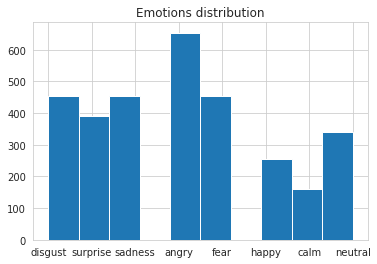

In [556]:
plt.title('Emotions distribution')
plt.hist(df_train['emotion_label'])
# plt.hist(y)
plt.show()

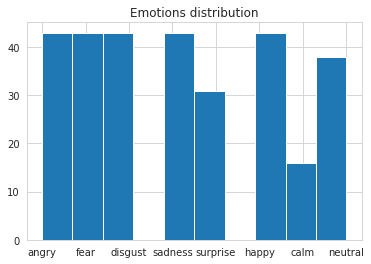

In [557]:
plt.title('Emotions distribution')
plt.hist(df_val['emotion_label'])
# plt.hist(y)
plt.show()

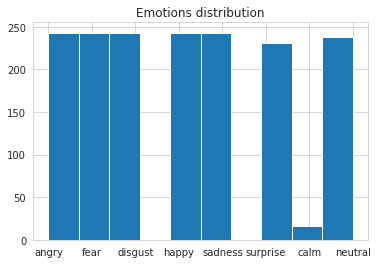

In [558]:
plt.title('Emotions distribution')
plt.hist(df_test['emotion_label'])
# plt.hist(y)
plt.show()

In [ ]:
df_train.shape

## Utils

In [608]:
def load_files(df):
    X = []
    for i in tqdm(df['path']): 
        X.append(librosa.load(i, res_type='kaiser_fast', sr=44100))
    return X

def extract_samples(X): 
    samples = []
    for ind,i in enumerate(X):
        samples.append(i[0])
    return samples 

def extract_labels(df): 
    labels = df['emotion_label'].copy()
    return labels 

def compute_lengths(samples): 
    lengths = [len(x) for x in samples]
    return lengths 

def check_outliers(lengths):
    # outliers
    lengths = np.array(lengths)
    print((lengths > 300000).sum())
    new_lengths = lengths[lengths < 300000]
    return new_lengths 

def compute_mean_length(lengths): 
    return lengths.mean()

def cut_and_pad(samples, labels, length_chosen = LENGTH_CHOSEN): 
    X_new = []
    y_new = []
    count = 0 
    for ind,i in enumerate(samples):
        if i.shape[0] < 300000:
            if i.shape[0] > length_chosen:
                new = i[:length_chosen]
                X_new.append(new)
            elif i.shape[0] < length_chosen:
                new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
                X_new.append(new)
            else:
                X_new.append(i)
            y_new.append(labels[count])
        count+=1
    
    return X_new, y_new

# Data Augmentation 
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# Data Augmentation 
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
    
def compute_mfccs(samples): 
    mfccs = []
    for i in tqdm(samples):
        mfcc = librosa.feature.mfcc(y=i, sr=44100, n_mfcc=40)
        mfcc = mfcc.T
        mfccs.append(mfcc)
    mfccs = np.array(mfccs)
    return mfccs 

def compute_mfccs_augmentation(samples, labels): 
    mfccs = []
    counter = 0 
    for i in tqdm(samples):

       # Weiner Filtering on original noise 
        samples_weiner = scipy.signal.wiener(i)
        is_fin = np.isfinite(samples_weiner).all()


        # Data Augmentation - Noise 
        noise_audio = noise(samples_weiner)

        # Data Augmentation - Pitch 
        pitch_audio = pitch(samples_weiner, sampling_rate=44100)


        # Data Augmentation -  pitch + noise 
        pn = pitch(noise_audio, sampling_rate = 44100)


        if is_fin: 
          # MFCC

          mfcc = librosa.feature.mfcc(y=i, sr=44100, n_mfcc=40)
          mfcc = mfcc.T
          mfccs.append(mfcc)

          mfcc_augmented = librosa.feature.mfcc(y=samples_weiner, sr=44100, n_mfcc=40)
          mfcc_augmented = mfcc_augmented.T
          mfccs.append(mfcc_augmented)

          mfcc_augmented_pitch = librosa.feature.mfcc(y=noise_audio, sr=44100, n_mfcc=40)
          mfcc_augmented_pitch = mfcc_augmented_pitch.T
          mfccs.append(mfcc_augmented_pitch)

          mfcc_augmented_p = librosa.feature.mfcc(y=pitch_audio, sr=44100, n_mfcc=40)
          mfcc_augmented_p = mfcc_augmented_p.T
          mfccs.append(mfcc_augmented_p) 

          mfcc_augmented_pn = librosa.feature.mfcc(y=pn, sr=44100, n_mfcc=40)
          mfcc_augmented_pn = mfcc_augmented_pn.T
          mfccs.append(mfcc_augmented_pn) 
    
    mfccs = np.array(mfccs)
    
    # Copy labels 
    y_prov = []
    y = labels 
    for i in range(len(y)): 
      y_prov.append(y[i])
      y_prov.append(y[i])
      y_prov.append(y[i])
      y_prov.append(y[i])
      y_prov.append(y[i])
    y = np.asarray(y_prov)

    return mfccs, y 





## Train

### Load samples and labels 

In [563]:
load_train = load_files(df_train)

100%|███████████████████████████████████████| 3160/3160 [01:05<00:00, 48.13it/s]


In [582]:
samples_train = extract_samples(load_train)

In [590]:
labels_train = extract_labels(df_train)

### Decide length

In [584]:
lengths = compute_lengths(samples_train) 

In [585]:
new_lengths = check_outliers(lengths) 

2


In [586]:
mean_length = compute_mean_length(new_lengths)

In [587]:
mean_length

126519.63679544015

### Cut and Pad

In [593]:
samples_train, labels_train = cut_and_pad(samples_train, labels_train)

In [594]:
samples_train = np.array(samples_train)
labels_train = np.array(labels_train)
print(samples_train.shape, labels_train.shape)

(3158,) (3158,)


### Feature Extraction - Without Data Augmentation 

In [609]:
mfccs_train = compute_mfccs(samples_train)

100%|███████████████████████████████████████| 3158/3158 [01:01<00:00, 51.17it/s]


In [610]:
mfccs_train.shape

(3158, 248, 40)

### Save features and labels

In [611]:
preprocess_path = "/home/helemanc/Desktop/Binary_Model/pre-processed"
mfccs_train_path = os.path.join(preprocess_path,"mfccs_train.pkl")
labels_train_path = os.path.join(preprocess_path,"labels_train.pkl")

with open(mfccs_train_path, 'wb') as f:
        pickle.dump(mfccs_train , f)
        
with open(labels_train_path, 'wb') as f:
        pickle.dump(labels_train , f)

### Feature Extraction - With Data Augmentation

In [612]:
mfccs_train_aug, labels_train_aug = compute_mfccs_augmentation(samples_train, labels_train)

100%|███████████████████████████████████████| 3158/3158 [25:42<00:00,  2.05it/s]


In [615]:
mfccs_train_aug.shape, labels_train_aug.shape

((15790, 248, 40), (15790,))

### Save features and labels

In [614]:
preprocess_path = "/home/helemanc/Desktop/Binary_Model/pre-processed"
mfccs_aug_train_path = os.path.join(preprocess_path,"mfccs_train_aug.pkl")
labels_aug_train_path = os.path.join(preprocess_path,"labels_train_aug.pkl")

with open(mfccs_aug_train_path, 'wb') as f:
        pickle.dump(mfccs_train_aug , f)
        
with open(labels_aug_train_path, 'wb') as f:
        pickle.dump(labels_train_aug , f)

## Val

### Load samples and labels

In [616]:
load_val = load_files(df_val)

100%|█████████████████████████████████████████| 300/300 [00:05<00:00, 57.61it/s]


In [617]:
samples_val = extract_samples(load_val)

In [618]:
labels_val = extract_labels(df_val)

### Cut and Pad 

In [619]:
samples_val, labels_val = cut_and_pad(samples_val, labels_val)

In [620]:
samples_val = np.array(samples_val)
labels_val = np.array(labels_val)
print(samples_val.shape, labels_val.shape)

(299,) (299,)


### Feature Extraction

In [621]:
mfccs_val = compute_mfccs(samples_val)

100%|█████████████████████████████████████████| 299/299 [00:05<00:00, 57.71it/s]


In [622]:
mfccs_val.shape

(299, 248, 40)

### Save features and labels

In [624]:
preprocess_path = "/home/helemanc/Desktop/Binary_Model/pre-processed"
mfccs_val_path = os.path.join(preprocess_path,"mfccs_val.pkl")
labels_val_path = os.path.join(preprocess_path,"labels_val.pkl")

with open(mfccs_val_path, 'wb') as f:
        pickle.dump(mfccs_val , f)
        
with open(labels_val_path, 'wb') as f:
        pickle.dump(labels_val , f)

## Test

### Load samples and labels

In [625]:
load_test = load_files(df_test)

100%|███████████████████████████████████████| 1700/1700 [00:31<00:00, 54.25it/s]


In [626]:
samples_test = extract_samples(load_test)

In [627]:
labels_test = extract_labels(df_test)

### Cut and Pad 

In [628]:
samples_test, labels_test = cut_and_pad(samples_test, labels_test)

In [629]:
samples_test = np.array(samples_test)
labels_test = np.array(labels_test)
print(samples_test.shape, labels_test.shape)

(1700,) (1700,)


### Feature Extraction

In [630]:
mfccs_test = compute_mfccs(samples_test)

100%|███████████████████████████████████████| 1700/1700 [00:36<00:00, 46.77it/s]


In [631]:
mfccs_test.shape

(1700, 248, 40)

### Save features and labels

In [632]:
preprocess_path = "/home/helemanc/Desktop/Binary_Model/pre-processed"
mfccs_test_path = os.path.join(preprocess_path,"mfccs_test.pkl")
labels_test_path = os.path.join(preprocess_path,"labels_test.pkl")

with open(mfccs_test_path, 'wb') as f:
        pickle.dump(mfccs_test , f)
        
with open(labels_test_path, 'wb') as f:
        pickle.dump(labels_test , f)

# Load features and Labels

In [209]:
preprocess_path = "/home/helemanc/Desktop/Binary_Model/pre-processed"
mfccs_train_path = os.path.join(preprocess_path,"mfccs_train.pkl")
labels_train_path = os.path.join(preprocess_path,"labels_train.pkl")

mfccs_aug_train_path = os.path.join(preprocess_path,"mfccs_train_aug.pkl")
labels_aug_train_path = os.path.join(preprocess_path,"labels_train_aug.pkl")

mfccs_val_path = os.path.join(preprocess_path,"mfccs_val.pkl")
labels_val_path = os.path.join(preprocess_path,"labels_val.pkl")

mfccs_test_path = os.path.join(preprocess_path,"mfccs_test.pkl")
labels_test_path = os.path.join(preprocess_path,"labels_test.pkl")


In [210]:
mfccs_train = pickle.load(open(mfccs_train_path, 'rb'))
labels_train = pickle.load(open(labels_train_path, 'rb'))

mfccs_train_aug = pickle.load(open(mfccs_aug_train_path, 'rb'))
labels_train_aug = pickle.load(open(labels_aug_train_path, 'rb'))

mfccs_val = pickle.load(open(mfccs_val_path, 'rb'))
labels_val = pickle.load(open(labels_val_path, 'rb'))

mfccs_test = pickle.load(open(mfccs_test_path, 'rb'))
labels_test = pickle.load(open(labels_test_path, 'rb'))

# Encode Labels - Binary 

In [211]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'calm':0,  'happy':0, 'sadness':1, 'surprise':0, 'angry':1}

In [64]:
y_train = pd.Series(labels_train).replace(emotion_enc)
y_train_aug = pd.Series(labels_train_aug).map(emotion_enc)
y_val = pd.Series(labels_val).map(emotion_enc)
y_test = pd.Series(labels_test).map(emotion_enc)

# Train, Val, Test (X) 

In [212]:
X_train = mfccs_train
X_train_aug = mfccs_train_aug 
X_val = mfccs_val
X_test = mfccs_test 

# Standard Scaling 

## Without Augmentation

In [213]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

## Save Scaler

In [67]:
data_model_path = "/home/helemanc/Desktop/Binary_Model/data_model"
scaler_path = os.path.join(data_model_path,"scaler.pkl")
with open(scaler_path, 'wb') as f:
     pickle.dump(scaler,f)

## Save scaled data 

In [68]:
X_train_path = os.path.join(data_model_path,"X_train.pkl")
X_test_path = os.path.join(data_model_path,"X_test.pkl")
X_val_path =  os.path.join(data_model_path,"X_val.pkl")
y_train_path = os.path.join(data_model_path,"y_train.pkl")
y_test_path = os.path.join(data_model_path,"y_test.pkl")
y_val_path = os.path.join(data_model_path,"y_val.pkl")



with open(scaler_path, 'wb') as f:
     pickle.dump(scaler,f)
        
with open(X_train_path, 'wb') as f:
     pickle.dump(X_train,f)
        
with open(X_test_path, 'wb') as f:
     pickle.dump(X_test,f)    
           
with open(X_val_path, 'wb') as f:
     pickle.dump(X_val,f)     
        
with open(y_train_path, 'wb') as f:
     pickle.dump(y_train,f)
        
with open(y_test_path, 'wb') as f:
     pickle.dump(y_test,f)
        
with open(y_val_path, 'wb') as f:
     pickle.dump(y_val,f)

## With Augmentation

In [57]:
from sklearn.preprocessing import StandardScaler
scaler_aug = StandardScaler()
X_train_aug = scaler_aug.fit_transform(X_train_aug.reshape(-1, X_train_aug.shape[-1])).reshape(X_train_aug.shape)
X_test_aug = scaler_aug.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_val_aug = scaler_aug.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

## Save Scaler

In [58]:
data_model_path = "/home/helemanc/Desktop/Binary_Model/data_model_augmented"
scaler_aug_path = os.path.join(data_model_path,"scaler_aug.pkl")
with open(scaler_aug_path, 'wb') as f:
     pickle.dump(scaler_aug,f)

In [59]:
X_train_path = os.path.join(data_model_path,"X_train_aug.pkl")
X_test_path = os.path.join(data_model_path,"X_test.pkl")
X_val_path =  os.path.join(data_model_path,"X_val.pkl")
y_train_path = os.path.join(data_model_path,"y_train_aug.pkl")
y_test_path = os.path.join(data_model_path,"y_test.pkl")
y_val_path = os.path.join(data_model_path,"y_val.pkl")



with open(scaler_path, 'wb') as f:
     pickle.dump(scaler,f)
        
with open(X_train_path, 'wb') as f:
     pickle.dump(X_train_aug,f)
        
with open(X_test_path, 'wb') as f:
     pickle.dump(X_test,f)    
           
with open(X_val_path, 'wb') as f:
     pickle.dump(X_val,f)     
        
with open(y_train_path, 'wb') as f:
     pickle.dump(y_train_aug,f)
        
with open(y_test_path, 'wb') as f:
     pickle.dump(y_test,f)
        
with open(y_val_path, 'wb') as f:
     pickle.dump(y_val,f)

# Model 

In [217]:
model = Sequential()

model.add(layers.Conv1D(128, 5,padding='same',
                 input_shape=(248,40), kernel_initializer=tf.keras.initializers.HeNormal(seed=0)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(4)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv1D(64, 5,padding='same', kernel_initializer=tf.keras.initializers.HeNormal(seed=0)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(4)))
model.add(layers.Dropout(0.1))

model.add(layers.Conv1D(32, 5,padding='same', kernel_initializer=tf.keras.initializers.HeNormal(seed=0)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(4)))
model.add(layers.Dropout(0.1))

model.add(layers.Flatten())
model.add(layers.Dense(32,  kernel_initializer=tf.keras.initializers.HeNormal(seed=0)))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_34 (Conv1D)           (None, 248, 128)          25728     
_________________________________________________________________
activation_48 (Activation)   (None, 248, 128)          0         
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 62, 128)           0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 62, 128)           0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 62, 64)            41024     
_________________________________________________________________
activation_49 (Activation)   (None, 62, 64)            0         
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 15, 64)          

# Training

## Without Augmentation

### Load Data

In [197]:
X_train = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/X_train.pkl", 'rb'))
X_val = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/X_val.pkl", 'rb'))
X_test = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/X_test.pkl", 'rb'))
y_train = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/y_train.pkl", 'rb'))
y_val = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/y_val.pkl", 'rb'))
y_test =  pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/y_test.pkl", 'rb'))

In [218]:
weight_path = "/home/helemanc/Desktop/Binary_Model/weights/binary_model_l1l2.hdf5"

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)
# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}


In [219]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

### Train

In [222]:
history = model.fit(X_train, y_train, batch_size=16, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, model_checkpoint], class_weight = class_weights)

Epoch 1/500
198/198 [==============================] - 2s 12ms/step - loss: 0.2392 - accuracy: 0.8870 - val_loss: 0.6471 - val_accuracy: 0.6656
Epoch 2/500
198/198 [==============================] - 2s 11ms/step - loss: 0.2354 - accuracy: 0.8958 - val_loss: 0.6715 - val_accuracy: 0.6555
Epoch 3/500
198/198 [==============================] - 2s 11ms/step - loss: 0.2051 - accuracy: 0.9069 - val_loss: 0.8688 - val_accuracy: 0.6020
Epoch 4/500
198/198 [==============================] - 2s 11ms/step - loss: 0.1968 - accuracy: 0.9142 - val_loss: 0.6790 - val_accuracy: 0.6957
Epoch 5/500
198/198 [==============================] - 2s 12ms/step - loss: 0.1730 - accuracy: 0.9253 - val_loss: 0.7215 - val_accuracy: 0.6923
Epoch 6/500
198/198 [==============================] - 2s 11ms/step - loss: 0.1602 - accuracy: 0.9348 - val_loss: 0.6770 - val_accuracy: 0.6856
Epoch 7/500
198/198 [==============================] - 2s 12ms/step - loss: 0.1417 - accuracy: 0.9424 - val_loss: 0.6547 - val_accuracy:

### Plot Training Graphs

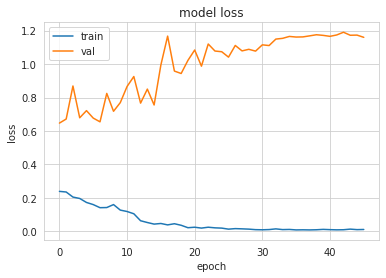

In [223]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

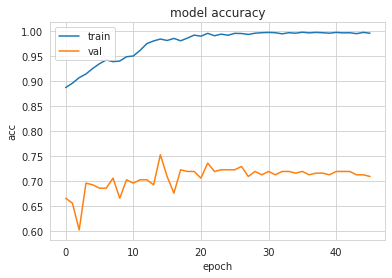

In [224]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Save Model

In [87]:
model.save("/home/helemanc/Desktop/Binary_Model/models/binary_model")

2021-08-23 11:45:07.689142: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/helemanc/Desktop/Binary_Model/models/binary_model/assets


### Evaluate Model

In [88]:
model_loaded = tf.keras.models.load_model("/home/helemanc/Desktop/Binary_Model/models/binary_model")

In [89]:
model_loaded.evaluate(X_test, y_test, batch_size=16)

107/107 [==============================] - 1s 5ms/step - loss: 1.7341 - accuracy: 0.5888


[1.7340623140335083, 0.5888235569000244]

In [90]:
from sklearn.metrics import classification_report
predictions = model_loaded.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.42      0.58      0.49       728
           1       0.56      0.41      0.47       972

    accuracy                           0.48      1700
   macro avg       0.49      0.49      0.48      1700
weighted avg       0.50      0.48      0.48      1700



## Without Augmentation - Shuffle Input Data

### Load Data

In [81]:
X_train = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/X_train.pkl", 'rb'))
X_val = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/X_val.pkl", 'rb'))
X_test = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/X_test.pkl", 'rb'))
y_train = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/y_train.pkl", 'rb'))
y_val = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/y_val.pkl", 'rb'))
y_test =  pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/y_test.pkl", 'rb'))

In [221]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [135]:
weight_path = "/home/helemanc/Desktop/Binary_Model/weights/binary_model_shuffle.hdf5"

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)
# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}


In [136]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

### Train

In [137]:
history = model.fit(X_train, y_train, batch_size=16, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, model_checkpoint], class_weight = class_weights)

Epoch 1/500
198/198 [==============================] - 4s 16ms/step - loss: 0.1199 - accuracy: 0.9797 - val_loss: 1.2262 - val_accuracy: 0.7291
Epoch 2/500
198/198 [==============================] - 3s 16ms/step - loss: 0.1204 - accuracy: 0.9796 - val_loss: 1.4017 - val_accuracy: 0.7057
Epoch 3/500
198/198 [==============================] - 3s 15ms/step - loss: 0.1086 - accuracy: 0.9812 - val_loss: 1.0301 - val_accuracy: 0.6823
Epoch 4/500
198/198 [==============================] - 3s 15ms/step - loss: 0.1166 - accuracy: 0.9803 - val_loss: 1.1104 - val_accuracy: 0.6756
Epoch 5/500
198/198 [==============================] - 3s 15ms/step - loss: 0.1198 - accuracy: 0.9822 - val_loss: 1.2360 - val_accuracy: 0.6957

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/500
198/198 [==============================] - 3s 15ms/step - loss: 0.0947 - accuracy: 0.9901 - val_loss: 1.3156 - val_accuracy: 0.7157
Epoch 7/500
198/198 [==============================] - 

### Plot Training Graphs

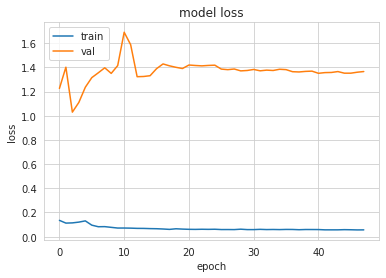

In [138]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

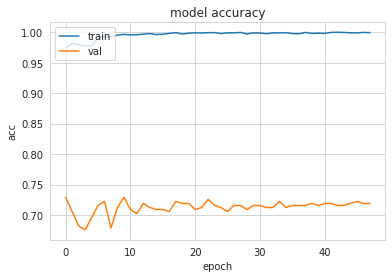

In [139]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Save Model

In [140]:
model.save("/home/helemanc/Desktop/Binary_Model/models/binary_model_shuffle")

INFO:tensorflow:Assets written to: /home/helemanc/Desktop/Binary_Model/models/binary_model_shuffle/assets


### Evaluate Model

In [141]:
model_loaded = tf.keras.models.load_model("/home/helemanc/Desktop/Binary_Model/models/binary_model_shuffle")

In [142]:
model_loaded.evaluate(X_test, y_test, batch_size=16)

107/107 [==============================] - 1s 4ms/step - loss: 1.6039 - accuracy: 0.6388


[1.6038637161254883, 0.6388235092163086]

In [143]:
from sklearn.metrics import classification_report
predictions = model_loaded.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.56      0.71      0.63       728
           1       0.73      0.59      0.65       972

    accuracy                           0.64      1700
   macro avg       0.65      0.65      0.64      1700
weighted avg       0.66      0.64      0.64      1700



## Without Augmentation - CrossValidation

### Load Data

In [125]:
X_train = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/X_train.pkl", 'rb'))
X_val = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/X_val.pkl", 'rb'))
X_test = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/X_test.pkl", 'rb'))
y_train = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/y_train.pkl", 'rb'))
y_val = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/y_val.pkl", 'rb'))
y_test =  pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/y_test.pkl", 'rb'))

In [126]:
#weight_path = "/home/helemanc/Desktop/Binary_Model/weights/binary_model.hdf5"

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1)

#model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path, 
#                                                      save_weights_only=True, 
#                                                      monitor='val_accuracy', 
#                                                      mode='max', 
#                                                      save_best_only=True)
# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}


In [127]:
def create_model(): 
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(248,40), kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(64))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

    model.summary()
    return model

### Train

In [128]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score

In [129]:
estimator= KerasRegressor(build_fn= create_model(), epochs=500, batch_size=16, verbose=0)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 248, 256)          51456     
_________________________________________________________________
activation_9 (Activation)    (None, 248, 256)          0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 31, 256)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 31, 256)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 31, 128)           163968    
_________________________________________________________________
activation_10 (Activation)   (None, 31, 128)           0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 7, 128)           

In [130]:
kfold= RepeatedKFold(n_splits=5, n_repeats=100)

In [132]:
results= cross_val_score(estimator, X_train, y_train, cv=kfold, n_jobs=1)  # 2 cpus
results.mean()  

nan

In [84]:
history = model.fit(X_train, y_train, batch_size=16, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop], class_weight = class_weights)

Epoch 1/500
198/198 [==============================] - 4s 17ms/step - loss: 0.9021 - accuracy: 0.7001 - val_loss: 0.9011 - val_accuracy: 0.5953
Epoch 2/500
198/198 [==============================] - 3s 16ms/step - loss: 0.5497 - accuracy: 0.8037 - val_loss: 0.9081 - val_accuracy: 0.5953
Epoch 3/500
198/198 [==============================] - 3s 16ms/step - loss: 0.5036 - accuracy: 0.8207 - val_loss: 0.9483 - val_accuracy: 0.5853
Epoch 4/500
198/198 [==============================] - 3s 16ms/step - loss: 0.4481 - accuracy: 0.8505 - val_loss: 0.9705 - val_accuracy: 0.5886
Epoch 5/500
198/198 [==============================] - 3s 16ms/step - loss: 0.3875 - accuracy: 0.8738 - val_loss: 0.8131 - val_accuracy: 0.6355
Epoch 6/500
198/198 [==============================] - 3s 16ms/step - loss: 0.3635 - accuracy: 0.8873 - val_loss: 0.9322 - val_accuracy: 0.6054
Epoch 7/500
198/198 [==============================] - 3s 16ms/step - loss: 0.3634 - accuracy: 0.8829 - val_loss: 0.8649 - val_accuracy:

### Plot Training Graphs

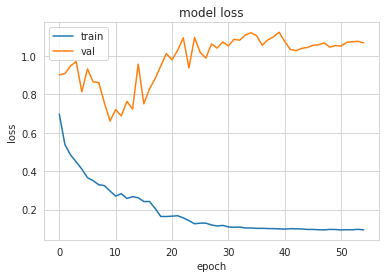

In [86]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

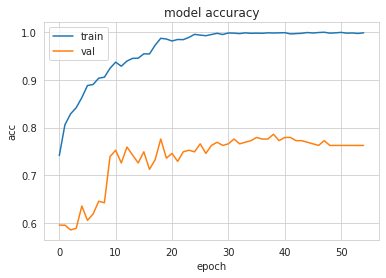

In [92]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Save Model

In [87]:
model.save("/home/helemanc/Desktop/Binary_Model/models/binary_model")

2021-08-23 11:45:07.689142: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/helemanc/Desktop/Binary_Model/models/binary_model/assets


### Evaluate Model

In [88]:
model_loaded = tf.keras.models.load_model("/home/helemanc/Desktop/Binary_Model/models/binary_model")

In [89]:
model_loaded.evaluate(X_test, y_test, batch_size=16)

107/107 [==============================] - 1s 5ms/step - loss: 1.7341 - accuracy: 0.5888


[1.7340623140335083, 0.5888235569000244]

In [90]:
from sklearn.metrics import classification_report
predictions = model_loaded.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.52      0.65      0.58       728
           1       0.67      0.54      0.60       972

    accuracy                           0.59      1700
   macro avg       0.60      0.60      0.59      1700
weighted avg       0.61      0.59      0.59      1700



## With Augmentation

### Load Data

In [114]:
X_train_aug = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model_augmented/X_train_aug.pkl", 'rb'))
X_val = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model_augmented/X_val.pkl", 'rb'))
X_test = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model_augmented/X_test.pkl", 'rb'))
y_train_aug = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model_augmented/y_train_aug.pkl", 'rb'))
y_val = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model_augmented/y_val.pkl", 'rb'))
y_test =  pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model_augmented/y_test.pkl", 'rb'))

In [115]:
(unique, counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   0 1144]
 [   1 2014]]


In [116]:
weight_path = "/home/helemanc/Desktop/Binary_Model/weights/binary_model_augmented.hdf5"

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)
# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_aug), y_train_aug)
class_weights = {l:c for l,c in zip(np.unique(y_train_aug), class_weights)}


In [117]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

### Train

In [118]:
history = model.fit(X_train_aug, y_train_aug, batch_size=16, epochs=500, validation_data=(X_val_aug, y_val),
           callbacks=[reduce_lr, early_stop, model_checkpoint], class_weight = class_weights)


Epoch 1/500
987/987 [==============================] - 15s 15ms/step - loss: 0.1497 - accuracy: 0.9660 - val_loss: 0.9984 - val_accuracy: 0.7090
Epoch 2/500
987/987 [==============================] - 14s 15ms/step - loss: 0.1421 - accuracy: 0.9711 - val_loss: 0.9997 - val_accuracy: 0.7224
Epoch 3/500
987/987 [==============================] - 14s 14ms/step - loss: 0.1576 - accuracy: 0.9684 - val_loss: 1.0661 - val_accuracy: 0.7157
Epoch 4/500
987/987 [==============================] - 12s 12ms/step - loss: 0.1722 - accuracy: 0.9675 - val_loss: 0.7942 - val_accuracy: 0.7726
Epoch 5/500
987/987 [==============================] - 14s 14ms/step - loss: 0.1705 - accuracy: 0.9713 - val_loss: 0.9018 - val_accuracy: 0.7525
Epoch 6/500
987/987 [==============================] - 15s 15ms/step - loss: 0.1794 - accuracy: 0.9692 - val_loss: 0.9474 - val_accuracy: 0.7492
Epoch 7/500
987/987 [==============================] - 16s 16ms/step - loss: 0.1753 - accuracy: 0.9745 - val_loss: 0.9878 - val_ac

### Plot Training Graphs

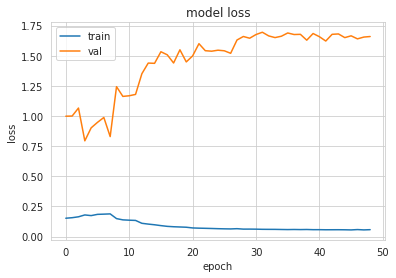

In [119]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

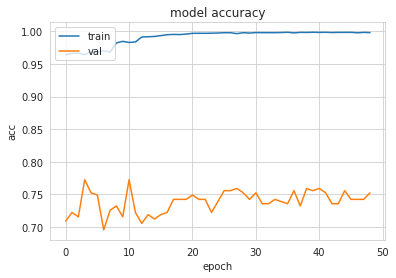

In [120]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Save Model

In [121]:
model.save("/home/helemanc/Desktop/Binary_Model/models/binary_model_aug")

INFO:tensorflow:Assets written to: /home/helemanc/Desktop/Binary_Model/models/binary_model_aug/assets


### Evaluate Model

In [122]:
model_loaded = tf.keras.models.load_model("/home/helemanc/Desktop/Binary_Model/models/binary_model_aug")

In [123]:
model_loaded.evaluate(X_test, y_test, batch_size=16)

107/107 [==============================] - 1s 4ms/step - loss: 341.3233 - accuracy: 0.5718


[341.3233337402344, 0.5717647075653076]

In [124]:
from sklearn.metrics import classification_report
predictions = model_loaded.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       728
           1       0.57      1.00      0.73       972

    accuracy                           0.57      1700
   macro avg       0.29      0.50      0.36      1700
weighted avg       0.33      0.57      0.42      1700

